# Set up

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, sampler
from tqdm import tqdm

# Load Data

In [2]:
X_train, y_train = torch.load("data/brats_train.pt")
X_val, y_val = torch.load("data/brats_val.pt")
X_test, y_test = torch.load("data/brats_test.pt")

In [3]:
class BraTSDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]  # (C, H, W), already normalized
        mask = self.y[idx]  # (H, W)

        if torch.any(mask > 3):
            print(f"Sample {idx} has label > 3. Clamping.")
            mask = torch.clamp(mask, 0, 3)

        if self.transform:
            img = self.transform(img)

        return img, mask


In [4]:
train_dataset = BraTSDataset(X_train, y_train)
test_dataset = BraTSDataset(X_test, y_test)

img, mask = train_dataset[0]
print(f'Image shape: {img.shape}, Mask shape: {mask.shape}')  # (B, C, H, W)

Image shape: torch.Size([3, 128, 128]), Mask shape: torch.Size([128, 128])


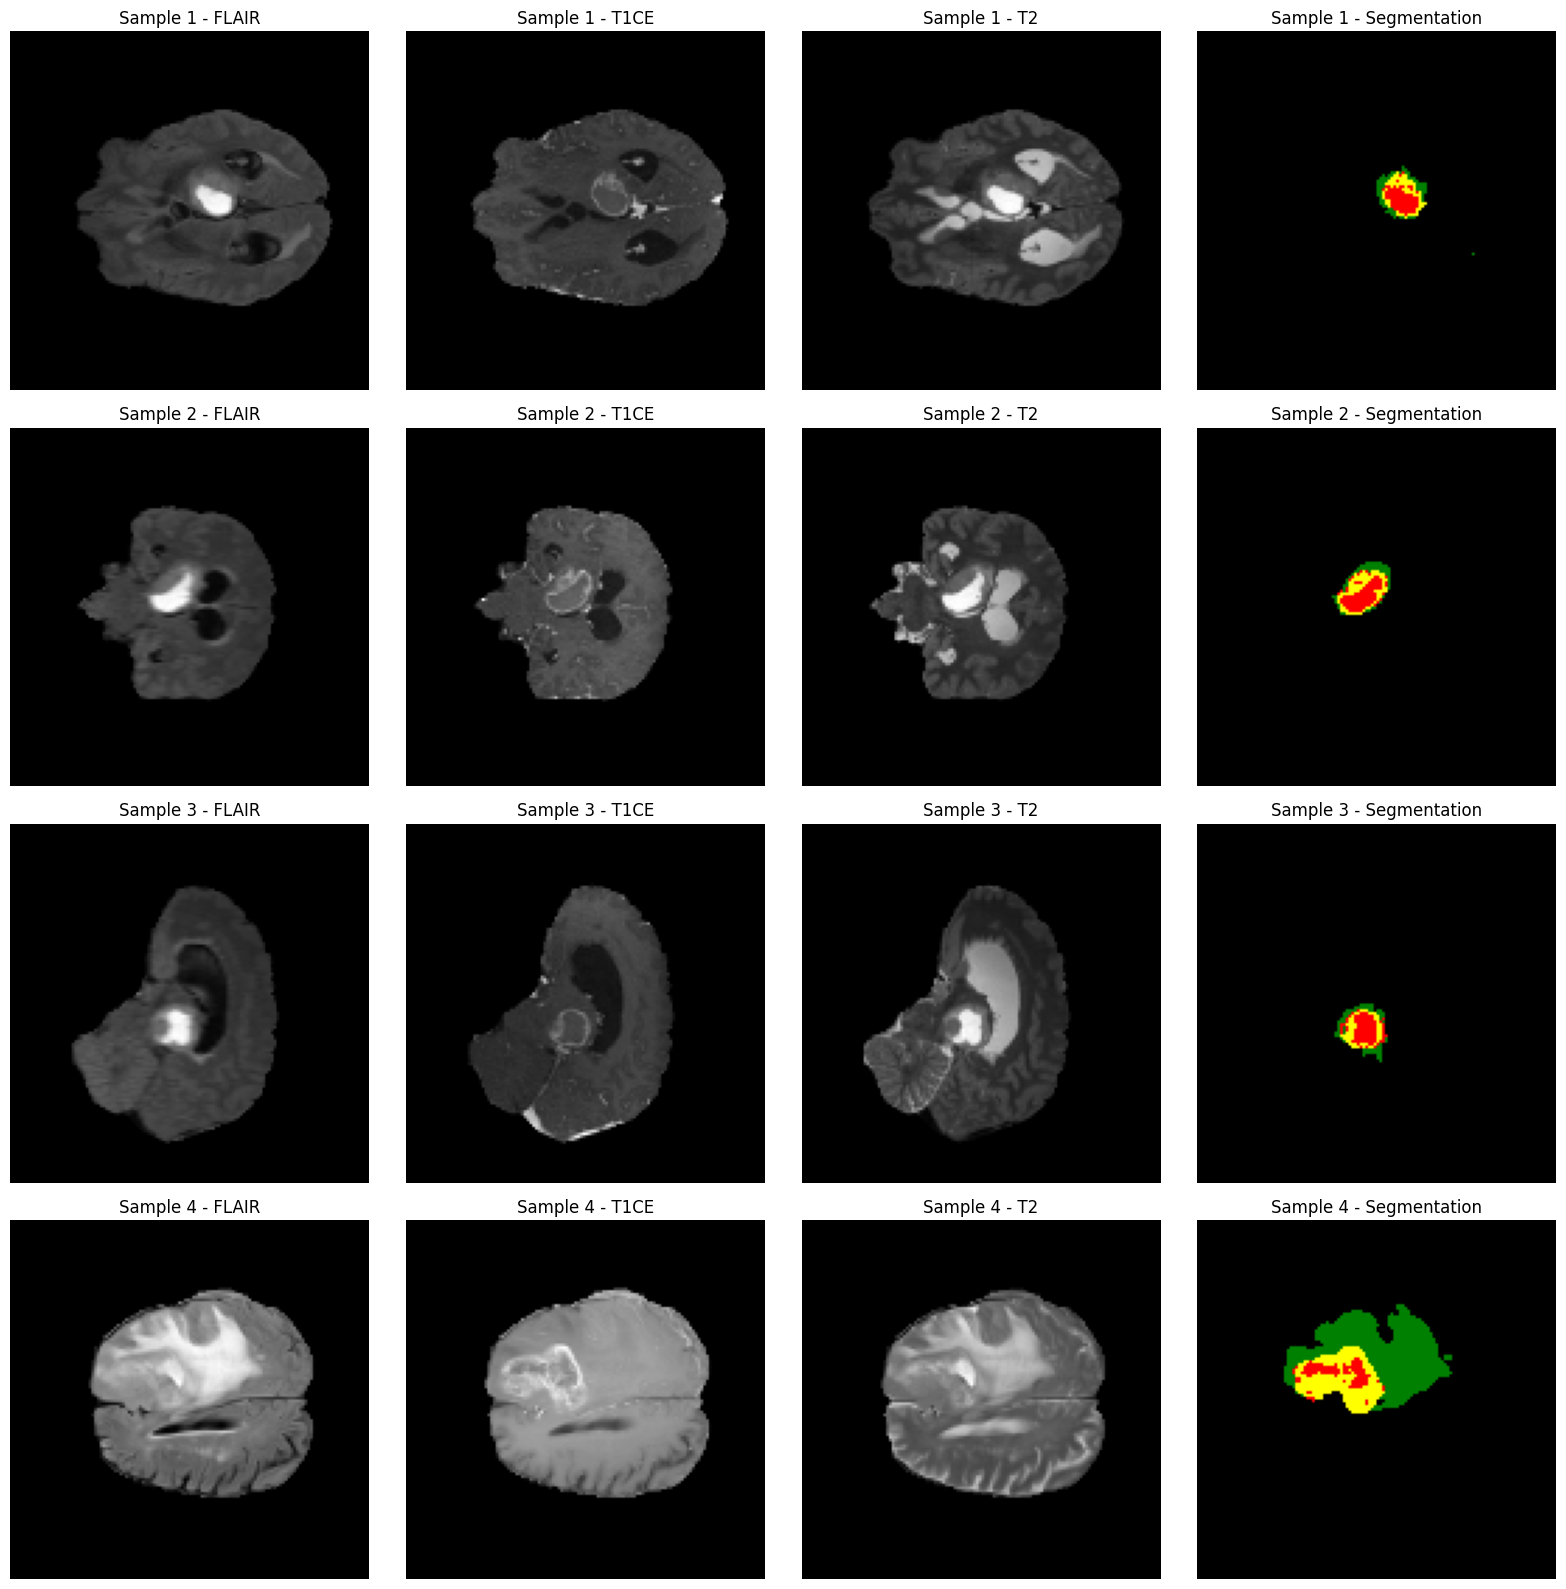

In [5]:
def plot_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))  # 3 inputs + 1 mask

    for i in range(num_samples):
        img, mask = dataset[i] # img: (3, H, W), mask: (H, W)
        img = img.cpu().numpy()
        mask = mask.cpu().numpy()

        flair = img[0]
        t1ce = img[1]
        t2 = img[2]

        axes[i, 0].imshow(flair, cmap='gray')
        axes[i, 0].set_title(f'Sample {i+1} - FLAIR')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(t1ce, cmap='gray')
        axes[i, 1].set_title(f'Sample {i+1} - T1CE')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(t2, cmap='gray')
        axes[i, 2].set_title(f'Sample {i+1} - T2')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(mask, cmap=ListedColormap(['black', 'red', 'green', 'yellow']))
        axes[i, 3].set_title(f'Sample {i+1} - Segmentation')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Plot samples from the training dataset
plot_samples(train_dataset, num_samples=4)

# UNet++

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = x.float()
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out


class NestedUNet(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(NestedUNet, self).__init__()
        out_channels = [64, 128, 256, 512, 1024]

        # Backbone
        self.conv0_0 = ConvBlock(in_channels, out_channels[0], out_channels[0])
        self.conv1_0 = ConvBlock(out_channels[0], out_channels[1], out_channels[1])
        self.conv2_0 = ConvBlock(out_channels[1], out_channels[2], out_channels[2])
        self.conv3_0 = ConvBlock(out_channels[2], out_channels[3], out_channels[3])
        self.conv4_0 = ConvBlock(out_channels[3], out_channels[4], out_channels[4])

        # Skip pathways
        self.conv0_1 = ConvBlock(out_channels[0] + out_channels[1], out_channels[0], out_channels[0])
        self.conv1_1 = ConvBlock(out_channels[1] + out_channels[2], out_channels[1], out_channels[1])
        self.conv2_1 = ConvBlock(out_channels[2] + out_channels[3], out_channels[2], out_channels[2])
        self.conv3_1 = ConvBlock(out_channels[3] + out_channels[4], out_channels[3], out_channels[3])

        self.conv0_2 = ConvBlock(out_channels[0]*2 + out_channels[1], out_channels[0], out_channels[0])
        self.conv1_2 = ConvBlock(out_channels[1]*2 + out_channels[2], out_channels[1], out_channels[1])
        self.conv2_2 = ConvBlock(out_channels[2]*2 + out_channels[3], out_channels[2], out_channels[2])

        self.conv0_3 = ConvBlock(out_channels[0]*3 + out_channels[1], out_channels[0], out_channels[0])
        self.conv1_3 = ConvBlock(out_channels[1]*3 + out_channels[2], out_channels[1], out_channels[1])

        self.conv0_4 = ConvBlock(out_channels[0]*4 + out_channels[1], out_channels[0], out_channels[0])

        # Pooling and upsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Classifier
        self.final = nn.Conv2d(out_channels[0], num_classes, kernel_size=1)

    def forward(self, x):
        # Backbone
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))

        # Input = previous conv + upsample lower conv
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up_sample(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up_sample(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up_sample(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up_sample(x4_0)], 1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up_sample(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up_sample(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up_sample(x3_1)], 1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up_sample(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up_sample(x2_2)], 1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up_sample(x1_3)], 1))
        output = self.final(x0_4)
        return output

# Loss

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.eps = torch.finfo(torch.float32).eps

    def forward(self, predict, target):
        predict = F.softmax(predict, dim=1)
        num_classes = predict.shape[1]
        dice = 0.0

        for c in range(num_classes):
            pred_flat = predict[:, c, :, :].contiguous().view(-1)
            target_flat = (target == c).float().view(-1)
            intersection = torch.sum(pred_flat * target_flat)
            union = torch.sum(pred_flat) + torch.sum(target_flat)
            dice_class = (2 * intersection + self.eps) / (union + self.eps)
            dice += 1 - dice_class

        return dice / num_classes


class DiceCELoss(nn.Module):
    def __init__(self, dice_weight=0.5, class_weights=None):
        super(DiceCELoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights) if class_weights is not None else nn.CrossEntropyLoss()
        self.dice_weight = dice_weight

    def forward(self, predict, target):
        dice = self.dice_loss(predict.float(), target.float())
        ce_target = F.one_hot(target.squeeze(1).long(), num_classes=4).permute(0,3,1,2)
        ce = self.ce_loss(predict.float(), ce_target.float())
        return self.dice_weight * dice + (1 - self.dice_weight) * ce

In [9]:
def IoU(pred_masks, true_masks):
    total_iou = 0
    num_classes = pred_masks.shape[1]
    pred_probs = torch.softmax(pred_masks, dim=1)

    for class_idx in range(num_classes):
        pred_mask = (torch.argmax(pred_probs.float(), dim=1) == class_idx).float()
        # true_mask = (true_masks[:, 0, :, :] == class_idx).float()
        true_mask = (true_masks == class_idx).float()
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()
        iou = intersection / union if union != 0 else 1  # Correct empty prediction
        total_iou += iou

    return total_iou / num_classes

# Training and Testing

In [10]:
def train(model, train_loader, num_epochs, optimizer, criterion, device, dtype, save_path, print_every=None):
    try:
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0.0
            total_iou = 0.0
            num_samples = 0

            for batch_idx, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = batch
                inputs = inputs.to(device, dtype=dtype)
                labels = labels.to(device, dtype=dtype)

                optimizer.zero_grad()
                out = model(inputs)
                loss = criterion(out, labels)
                loss.backward()
                optimizer.step()

                with torch.no_grad():  # Disable gradient calculation
                    iou = IoU(out, labels)
                    total_iou += iou * inputs.size(0)
                    num_samples += inputs.size(0)

                total_loss += loss.item() * inputs.size(0)

                if print_every is not None and batch_idx % print_every == 0:
                    print('  Step [{}/{}], Loss: {:.4f}, IoU: {:.4f}'.format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item(), iou))

            average_loss = total_loss / num_samples
            average_iou = total_iou / num_samples
            print('  Average Loss: {:.4f}, Average IoU: {:.4f}'.format(average_loss, average_iou))

        torch.save(model, save_path)

    except Exception as e:
        print(e)
        torch.save(model, save_path)

In [11]:
def test(model, val_loader, criterion, device, dtype):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            inputs, labels = batch
            inputs = inputs.to(device, dtype=dtype)
            labels = labels.to(device, dtype=dtype)

            out = model(inputs)
            loss = criterion(out, labels)
            iou = IoU(out, labels)

            total_iou += iou * inputs.size(0)
            total_loss += loss.item() * inputs.size(0)
            num_samples += inputs.size(0)

        average_loss = total_loss/num_samples
        average_iou = total_iou/num_samples

        print('Test Loss: {:.4f}, Test IoU: {:.4f}'.format(average_loss, average_iou))

In [12]:
def compute_class_weights(y_train, num_classes):
    y_flat = y_train.view(-1)
    counts = torch.bincount(y_flat, minlength=num_classes).float()
    total = counts.sum()
    weights = total / counts
    return weights / weights.sum()

print(f"Train class weights ~ {compute_class_weights(y_train, 4)}")
print(f"Test class weights  ~ {compute_class_weights(y_test, 4)}")

Train class weights ~ tensor([0.0043, 0.3861, 0.1883, 0.4213])
Test class weights  ~ tensor([0.0043, 0.3068, 0.1746, 0.5144])


In [13]:
# Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print_every = None

input_channels = 3
num_classes = 4
class_weights = compute_class_weights(y_train, num_classes).to(device)
dice_weight = 0.5
learning_rate = 0.001
batch_size = 16
num_epochs = 50

save_path = f'checkpoints/unet++_dce{dice_weight:.0e}_invfreqw_adam{learning_rate:.0e}_batch{batch_size}_epoch{num_epochs}.pth'.replace('+0', '').replace('-0', '-')
model = NestedUNet(num_classes, input_channels)
criterion = DiceCELoss(dice_weight=dice_weight, class_weights=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)

print(save_path)

checkpoints/unet++_dce5e-1_invfreqw_adam1e-3_batch16_epoch50.pth


In [14]:
# from torch.utils.data import Subset
# train_subset = Subset(train_dataset, list(range(8)))
# train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train(model, train_loader, num_epochs, optimizer, criterion, device, dtype, save_path, print_every)

Epoch 1/30: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Average Loss: 0.2729, Average IoU: 0.1831


Epoch 2/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2591, Average IoU: 0.1902


Epoch 3/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2548, Average IoU: 0.2512


Epoch 4/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2482, Average IoU: 0.2543


Epoch 5/30: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Average Loss: 0.2439, Average IoU: 0.2660


Epoch 6/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2401, Average IoU: 0.2800


Epoch 7/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2367, Average IoU: 0.3013


Epoch 8/30: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Average Loss: 0.2340, Average IoU: 0.3236


Epoch 9/30: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Average Loss: 0.2310, Average IoU: 0.3142


Epoch 10/30: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Average Loss: 0.2276, Average IoU: 0.3398


Epoch 11/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2250, Average IoU: 0.3574


Epoch 12/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2232, Average IoU: 0.3605


Epoch 13/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2245, Average IoU: 0.3459


Epoch 14/30: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Average Loss: 0.2228, Average IoU: 0.3748


Epoch 15/30: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Average Loss: 0.2198, Average IoU: 0.3922


Epoch 16/30: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Average Loss: 0.2169, Average IoU: 0.4104


Epoch 17/30: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Average Loss: 0.2151, Average IoU: 0.4264


Epoch 18/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2132, Average IoU: 0.4398


Epoch 19/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2100, Average IoU: 0.4592


Epoch 20/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2089, Average IoU: 0.4651


Epoch 21/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2059, Average IoU: 0.4870


Epoch 22/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2042, Average IoU: 0.4970


Epoch 23/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.2016, Average IoU: 0.5213


Epoch 24/30: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Average Loss: 0.1997, Average IoU: 0.5349


Epoch 25/30: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Average Loss: 0.1973, Average IoU: 0.5395


Epoch 26/30: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Average Loss: 0.1950, Average IoU: 0.5508


Epoch 27/30: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Average Loss: 0.1926, Average IoU: 0.5792


Epoch 28/30: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Average Loss: 0.1903, Average IoU: 0.6028


Epoch 29/30: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Average Loss: 0.1885, Average IoU: 0.6232


Epoch 30/30: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Average Loss: 0.1913, Average IoU: 0.5957


# Visualize Segmentation Results

In [14]:
# Load the saved model
saved_model_path = 'checkpoints/unet++_dce5_wauto_adam_batch16_epoch50.pth'
loaded_model = torch.load(saved_model_path)
loaded_model.eval()
loaded_model.to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/unet++_dce5_wauto_adam_batch16_epoch50.pth'

In [16]:
def calculate_metrics(model, dataloader, device=torch.device('cuda'), num_classes=4, eps=torch.finfo(torch.float32).eps):
    model.eval()
    total_iou = 0.0
    total_dice = 0.0
    num_samples = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.long)

            outputs = model(imgs)  # (B, C, H, W)
            pred_masks = torch.argmax(outputs, dim=1)  # (B, H, W)

            dice_sum = 0.0
            iou_sum = 0.0
            for c in range(num_classes):
                pred_cls = (pred_masks == c).float()
                true_cls = (masks == c).float()

                intersection = torch.sum(pred_cls * true_cls)
                union = torch.sum((pred_cls + true_cls) > 0)
                iou = (intersection + eps) / (union + eps)
                dice = (2. * intersection + eps) / (torch.sum(pred_cls) + torch.sum(true_cls) + eps)

                dice_sum += dice.item()
                iou_sum += iou.item()

            total_dice += dice_sum / num_classes
            total_iou += iou_sum / num_classes
            num_samples += 1

    return {
        'IoU': total_iou / num_samples,
        'Dice': total_dice / num_samples
    }

In [17]:
# Calculate metrics on the test set
vis_test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

metrics = calculate_metrics(loaded_model, vis_test_loader, device=device)
print(f"Test IoU:  {metrics['IoU']:.4f}")
print(f"Test Dice: {metrics['Dice']:.4f}")

Test IoU: 0.2450
Test Dice: 0.1928


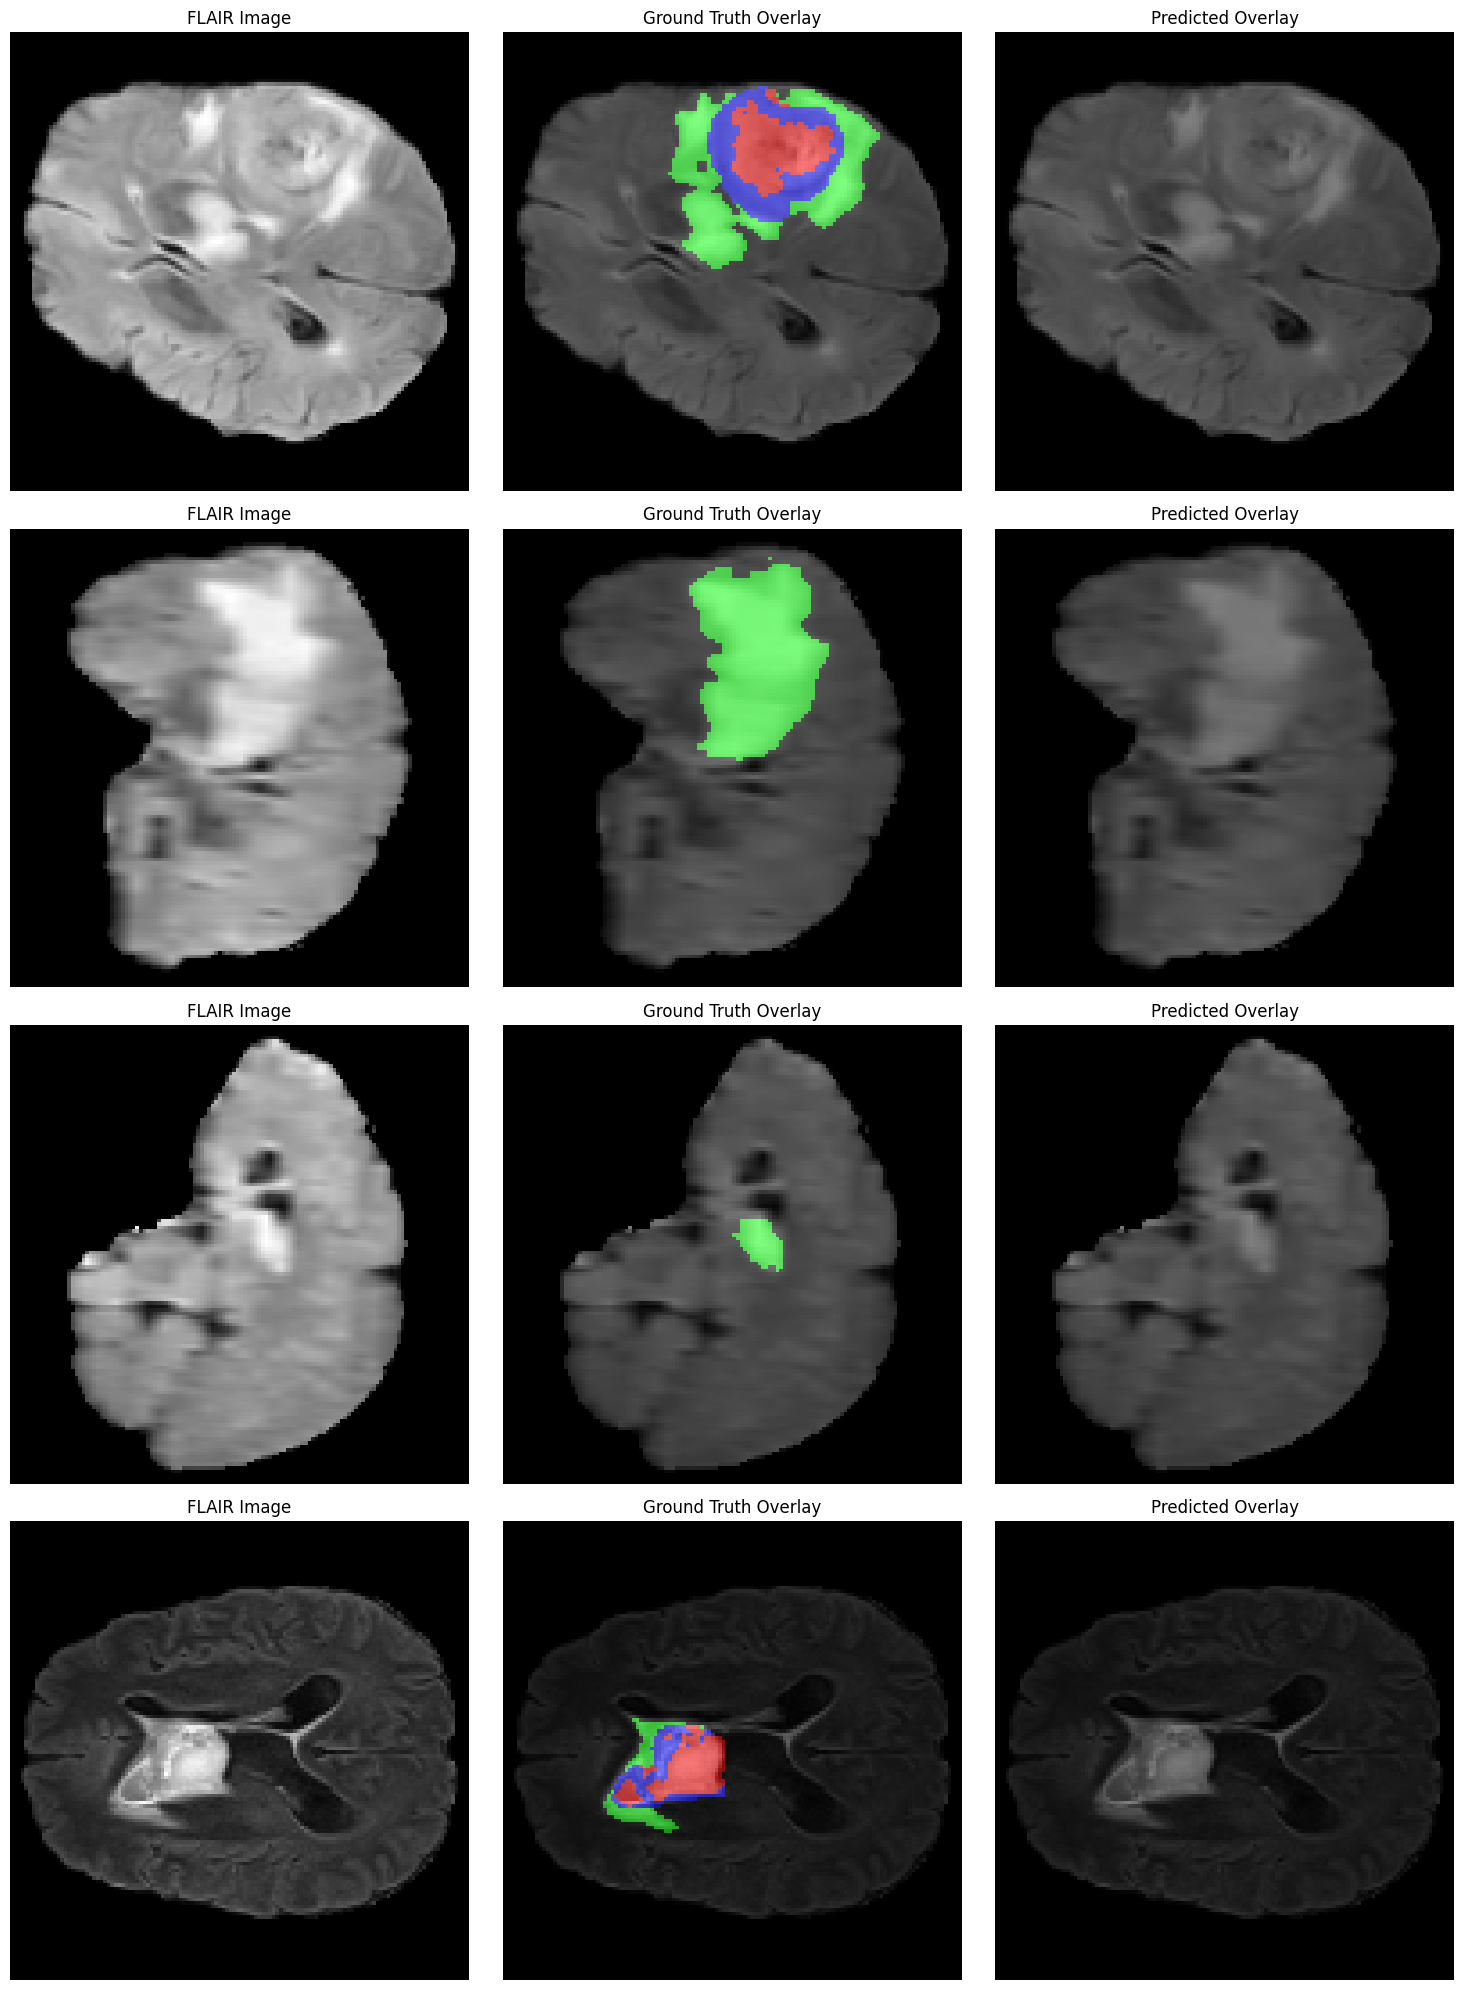

In [18]:
# Visualize segmentation overlays
def visualize_segmentation_overlay(model, dataloader, num_samples=4, device=torch.device('cuda')):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    count = 0
    with torch.no_grad():
        for images, masks in dataloader:
            batch_size = images.size(0)
            for b in range(batch_size):
                if count >= num_samples:
                    break

                image = images[b].to(device).unsqueeze(0)  # [1, 3, H, W]
                mask = masks[b].to(device)  # [H, W]

                output = model(image)  # [1, C, H, W]
                pred_mask = torch.argmax(torch.softmax(output, dim=1), dim=1)[0].cpu().numpy()
                mask_np = mask.cpu().numpy()
                flair_np = image[0, 0].cpu().numpy()

                flair_np = (flair_np - flair_np.min()) / (flair_np.max() - flair_np.min() + 1e-5)
                flair_rgb = np.stack([flair_np]*3, axis=-1)

                cmap = ListedColormap(['black', 'red', 'green', 'yellow'])
                gt_overlay = 0.5 * flair_rgb + 0.5 * cmap(mask_np)[..., :3]
                pred_overlay = 0.5 * flair_rgb + 0.5 * cmap(pred_mask)[..., :3]

                # Plotting
                axes[count, 0].imshow(flair_np, cmap='gray')
                axes[count, 0].set_title("FLAIR Image")
                axes[count, 0].axis('off')

                axes[count, 1].imshow(gt_overlay)
                axes[count, 1].set_title("Ground Truth Overlay")
                axes[count, 1].axis('off')

                axes[count, 2].imshow(pred_overlay)
                axes[count, 2].set_title("Predicted Overlay")
                axes[count, 2].axis('off')

                count += 1
            if count >= num_samples:
                break

    plt.tight_layout()
    plt.show()


visualize_segmentation_overlay(loaded_model, vis_test_loader, num_samples=4, device=device)

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "checkpoints/unet++_dce5e-1_invfreqw_adam1e-3_batch32_epoch50_uncrop.pth"
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# === Load model ===
model = torch.load(model_path, map_location=device)
model.eval()
model.to(device)

# === Load consistent test instance ===
fixed_index = 42
img, _ = test_dataset[fixed_index]
img_input = img.unsqueeze(0).to(device)  # (1, 3, H, W)

# === Predict ===
with torch.no_grad():
    output = model(img_input)  # (1, C, H, W)
    pred_mask = torch.argmax(torch.softmax(output, dim=1), dim=1)[0].cpu().numpy()

# === Extract T1 and normalize ===
t1 = img[2].numpy()
t1_norm = (t1 - t1.min()) / (t1.max() - t1.min() + 1e-5)
t1_rgb = np.stack([t1_norm]*3, axis=-1)

# === Overlay predicted mask ===
cmap = ListedColormap(['black', 'red', 'green', 'yellow'])
pred_overlay = 0.5 * t1_rgb + 0.5 * cmap(pred_mask)[..., :3]

# === Save the result ===
plt.imsave(os.path.join(output_dir, f"overlay_predicted_on_T1_unetpp_idx{fixed_index}.png"), pred_overlay)


: 